In [11]:

#!pip install datasets transformers torch pandas numpy faker
#!pip install tf-keras
#!pip install wordcloud
#!pip install transformers[torch]
#!pip install accelerate>=0.26.0
#!pip install nltk


In [16]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [12]:
import os
import torch
import pandas as pd
import string
from collections import Counter
import nltk
from nltk.util import ngrams
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the .pkl file into a pandas DataFrame

df = pd.read_pickle(r"merged_training.pkl") 

# Display the first 5 rows
df.head()

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


In [4]:
# perform based exploration on data

# Basic exploration
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())



<class 'pandas.core.frame.DataFrame'>
Index: 416809 entries, 27383 to 64703
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      416809 non-null  object
 1   emotions  416809 non-null  object
dtypes: object(2)
memory usage: 9.5+ MB
None
                                                 text emotions
count                                          416809   416809
unique                                         393822        6
top     i feel more adventurous willing to take risks      joy
freq                                               16   141067
text        0
emotions    0
dtype: int64


In [5]:
# Check Unique Values for emotion column
print(df['emotions'].unique())


['sadness' 'joy' 'love' 'anger' 'fear' 'surprise']


### Visualization

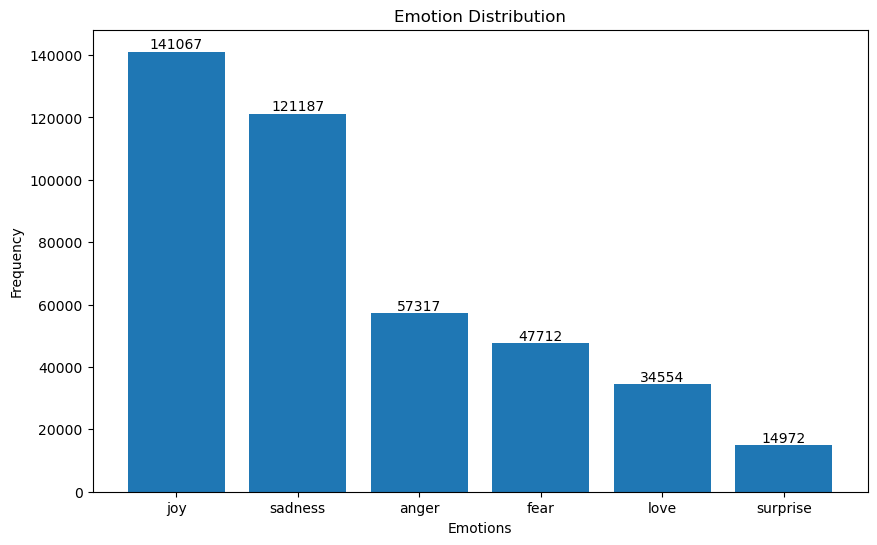

In [6]:
# Emotions Category Distribution

import matplotlib.pyplot as plt

emotion_counts = df['emotions'].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(emotion_counts.index, emotion_counts.values)

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

plt.xlabel("Emotions")
plt.ylabel("Frequency")
plt.title("Emotion Distribution")
plt.show()


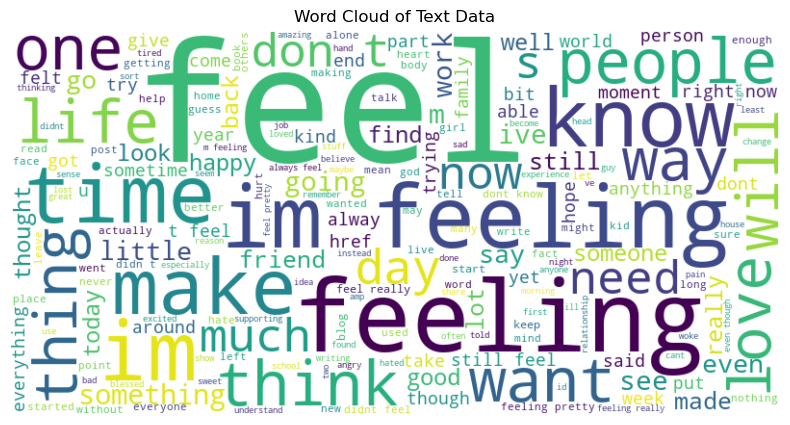

In [7]:
# Word Cloud for text column

from wordcloud import WordCloud

if 'text' in df.columns:
  text = ' '.join(df['text'].astype(str))  # Combine all text data
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title('Word Cloud of Text Data')
  plt.show()
else:
  print("No 'text' column found in the DataFrame. Skipping word cloud generation.")

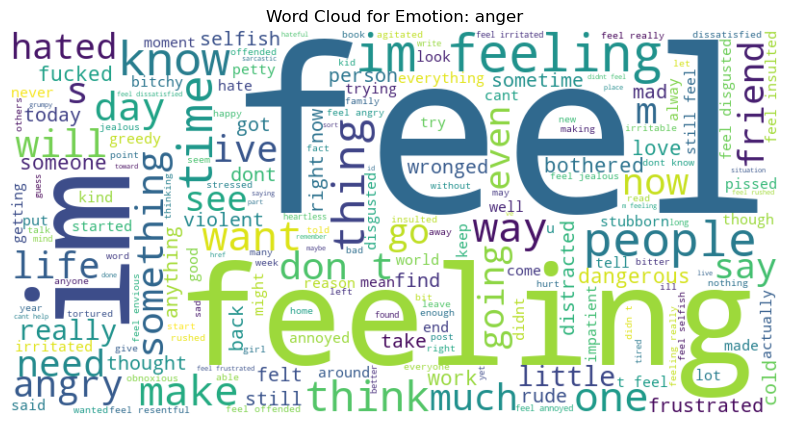

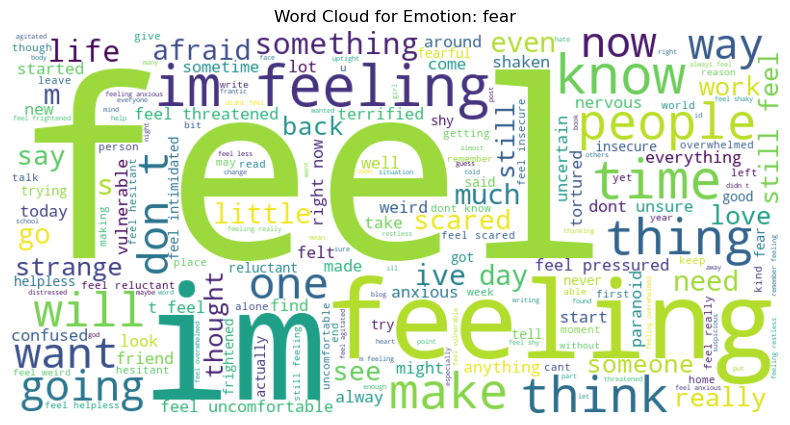

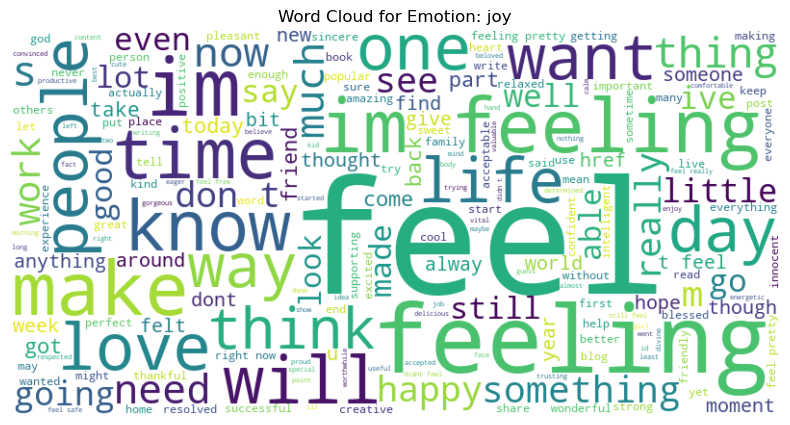

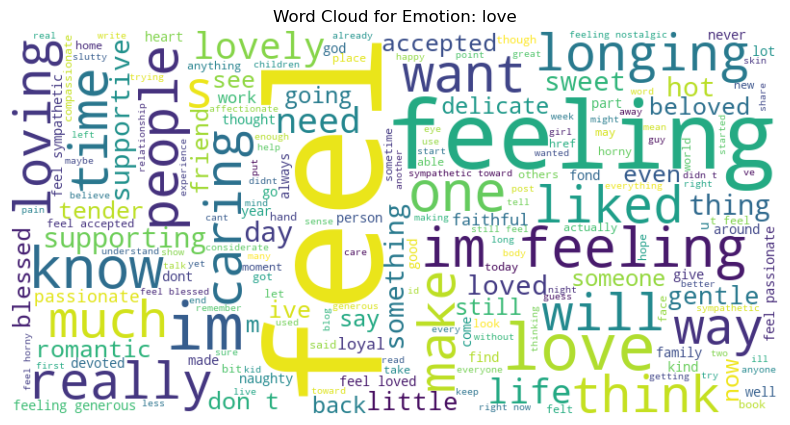

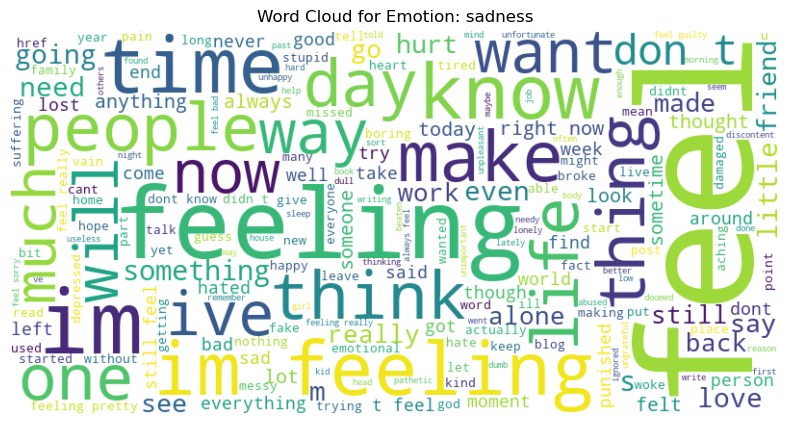

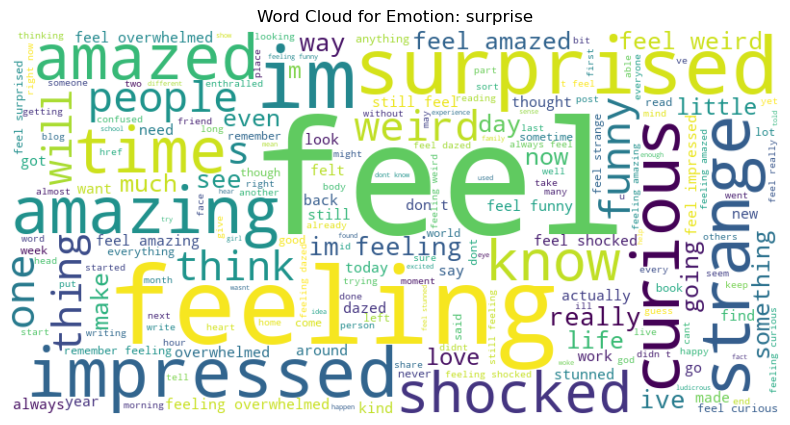

In [8]:
# visualize word cloud for each emotion category

# Group the DataFrame by emotion
emotion_groups = df.groupby('emotions')

# Iterate through each emotion group and generate a word cloud
for emotion, group in emotion_groups:
    text = ' '.join(group['text'].astype(str))  # Combine all text for this emotion
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Emotion: {emotion}')
    plt.show()


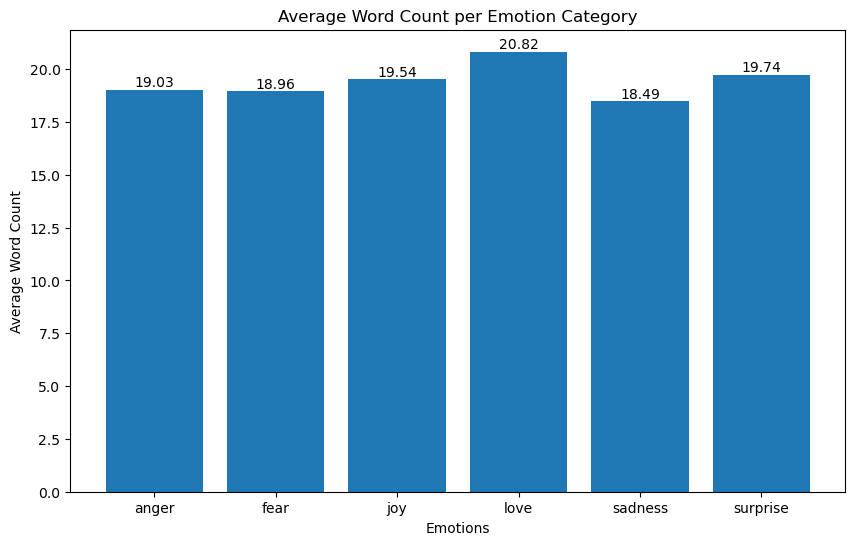

In [9]:
# Visualize Word Count per Emotion Category

if 'text' in df.columns and 'emotions' in df.columns:
    # Calculate average word count for each emotion
    df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))
    avg_word_counts = df.groupby('emotions')['word_count'].mean()

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(avg_word_counts.index, avg_word_counts.values)
    plt.xlabel("Emotions")
    plt.ylabel("Average Word Count")
    plt.title("Average Word Count per Emotion Category")

    # Add labels to the bars
    for bar, value in zip(bars, avg_word_counts.values):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 2), ha='center', va='bottom')

    plt.show()
else:
    print("Either 'text' or 'emotions' column not found in the DataFrame.")


#### Data Preprocessing

In [10]:
# Data Preprocessing
# convert emotions column from text to numbers

# Define custom emotion mapping
emotion_mapping = {
    "sadness": 0,
    "joy": 1,
    "love": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5
}

# Apply the mapping to encode emotions
df['emotion_encoded'] = df['emotions'].map(emotion_mapping)

# Display the updated DataFrame
print(df)

                                                     text emotions  \
27383   i feel awful about it too because it s my job ...  sadness   
110083                              im alone i feel awful  sadness   
140764  ive probably mentioned this before but i reall...      joy   
100071           i was feeling a little low few days back  sadness   
2837    i beleive that i am much more sensitive to oth...     love   
...                                                   ...      ...   
566     that was what i felt when i was finally accept...      joy   
36236   i take every day as it comes i m just focussin...     fear   
76229       i just suddenly feel that everything was fake  sadness   
131640  im feeling more eager than ever to claw back w...      joy   
64703   i give you plenty of attention even when i fee...  sadness   

        word_count  emotion_encoded  
27383           26                0  
110083           5                0  
140764          27                1  
100071 

In [11]:

# Drop column created for vis

if 'word_count' in df.columns:
    df = df.drop('word_count', axis=1)
    print("Column 'word_count' dropped successfully.")
else:
    print("Column 'word_count' not found in the DataFrame.")

# Now you can continue with other operations on your dataframe without the 'word_count' column.
print(df.head())


Column 'word_count' dropped successfully.
                                                     text emotions  \
27383   i feel awful about it too because it s my job ...  sadness   
110083                              im alone i feel awful  sadness   
140764  ive probably mentioned this before but i reall...      joy   
100071           i was feeling a little low few days back  sadness   
2837    i beleive that i am much more sensitive to oth...     love   

        emotion_encoded  
27383                 0  
110083                0  
140764                1  
100071                0  
2837                  2  


In [18]:
# Train-Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'], df['emotion_encoded'], test_size=0.3, random_state=42, stratify=df['emotion_encoded'])


In [19]:
# Load Pretrained Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(texts):
    return tokenizer(texts.tolist(), padding="max_length", truncation=True, max_length=128)

# Tokenize text data
train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)


In [14]:
# Convert to PyTorch Dataset
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset objects
train_dataset = EmotionDataset(train_encodings, train_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

print("Dataset is preprocessed and ready for training!")

Dataset is preprocessed and ready for training!


In [15]:
# Load Pretrained Model
num_labels = len(emotion_mapping)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    fp16=True,
    gradient_accumulation_steps=4
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)


In [17]:

# Disable Weights & Biases logging to prevent API key prompt
os.environ["WANDB_DISABLED"] = "true"
# Train Model
trainer.train()


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
trainer.save_model(f"./fine_tuned_{model_name}")
tokenizer.save_pretrained(f"./fine_tuned_{model_name}")

predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), dim=-1)
labels = predictions.label_ids

precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
acc = accuracy_score(labels, preds)

results[model_name] = {"accuracy": acc, "precision": precision, "recall": recall, "f1_score": f1}
print(f"{model_name} Performance:", results[model_name])

In [ ]:
models = list(results.keys())
accuracies = [results[m]['accuracy'] for m in models]
f1_scores = [results[m]['f1_score'] for m in models]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color='blue', alpha=0.6, label='Accuracy')
plt.bar(models, f1_scores, color='red', alpha=0.6, label='F1 Score')
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.show()

In [ ]:
pretrained_classifier = pipeline("text-classification", model="distilbert-base-uncased", tokenizer="distilbert-base-uncased")
fine_tuned_classifier = pipeline("text-classification", model="./fine_tuned_distilbert-base-uncased", tokenizer="./fine_tuned_distilbert-base-uncased")

In [ ]:
test_text = "I am feeling very happy today!"
pretrained_pred = pretrained_classifier(test_text)
fine_tuned_pred = fine_tuned_classifier(test_text)

print("Pre-trained Model Prediction:", pretrained_pred)
print("Fine-tuned Model Prediction:", fine_tuned_pred)

In [ ]:
# # Evaluate Model
# results = trainer.evaluate()
# print("Evaluation Results:", results)